In [2]:
%run setup.py

In [3]:
t, y = np.loadtxt('../lc/10080943_lc.txt', usecols=(0,1)).T

from scipy.ndimage import gaussian_filter
from maelstrom.utils import amplitude_spectrum
y_low = gaussian_filter(y,1.8)
y_high = y - y_low

array([<matplotlib.axes._subplots.AxesSubplot object at 0x110e4dfd0>,
      dtype=object)

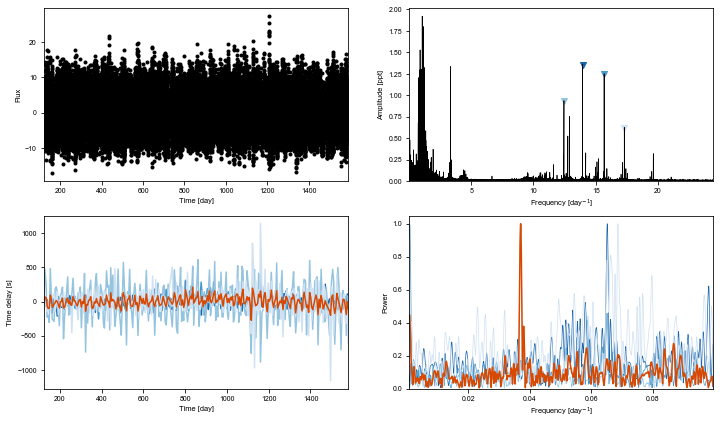

In [4]:
ms = Maelstrom(t, y, freq=np.array([13.94758557, 15.68333011, 
                                    12.45257641,  
                                    17.30504092,
                                   ]))
ms.first_look(segment_size=5)

In [9]:
ms.setup_orbit_model(period=15.335878873082686)
opt = ms.optimize()

In [5]:
freq = ms.freq
time, flux = ms.time, ms.flux

In [6]:
pinned_lt = [
    44.,
    -43.
]
nu_arr_positive = np.array([
    13.94758524
])
nu_arr_negative = np.array([
    15.68332996, 12.45257786
])

In [7]:
period_guess, a_guess = 15.335878873082686, 43.18400031048695

In [18]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(period_guess), sd=10,
                                      testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(flux)), sd=10, testval=0.)
    a1sini = pm.Normal('a1sini', mu=pinned_lt[0], sd=10, testval=pinned_lt[0])
    a2sini = pm.Normal('a2sini', mu=pinned_lt[1], sd=10, testval=pinned_lt[1])
    nu1 = pm.Normal('nu1', mu=nu_arr_positive, sd=0.001, testval=nu_arr_positive, shape=len(nu_arr_positive))
    nu2 = pm.Normal('nu2', mu=nu_arr_negative, sd=0.001, testval=nu_arr_negative, shape=len(nu_arr_negative))
    
    mean = pm.Normal("mean", mu=0.0, sd=1., testval=0.00)
    omega = xo.distributions.Angle("omega", testval=0)
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0)
    
    orbit1 = Orbit(period=period, 
                  lighttime=a1sini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu1)
    
    orbit2 = Orbit(period=period, 
                  lighttime=a2sini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu2)
    
    full_lc = orbit1.get_lightcurve_model(time, flux) + orbit2.get_lightcurve_model(time, flux) + mean
    
#     # GP parameters
    logw0 = pm.Bound(pm.Normal,
                         lower=np.log(2*np.pi/100.0),
                         upper=np.log(2*np.pi/0.5))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                    testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    pm.Potential("obs", gp.log_likelihood(flux - full_lc))

In [14]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
#     map_params = xo.optimize(start=map_params, vars=[W_hat_cos_neg, W_hat_cos_pos, W_hat_sin_neg, W_hat_sin_pos])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu1, nu2])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[a1sini, a2sini])
    map_params = xo.optimize(start=map_params, vars=[omega, eccen])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, vars=all_but)

[phi_angle__, logs_lc, a1sini, a2sini, nu1, nu2, mean, omega_angle__, eccen_interval__, logw0_interval__, logpower]


optimizing logp for variables: [mean]
5it [00:00,  9.52it/s, logp=-3.836893e+05]
message: Optimization terminated successfully.
logp: -383689.3692174602 -> -383689.3473209515
optimizing logp for variables: [logs_lc]
10it [00:00, 17.42it/s, logp=-1.902093e+05]
message: Optimization terminated successfully.
logp: -383689.3473209515 -> -190209.27938830102
optimizing logp for variables: [phi]
15it [00:00, 15.69it/s, logp=-1.901887e+05]
message: Optimization terminated successfully.
logp: -190209.27938830102 -> -190188.65225111056
optimizing logp for variables: [nu2, nu1]
63it [00:04, 14.42it/s, logp=-1.901886e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -190188.65225111056 -> -190188.64248278816
optimizing logp for variables: [logpower, logw0, eccen, omega, mean, nu2, nu1, a2sini, a1sini, logs_lc, phi]
189it [00:15, 12.36it/s, logp=-1.302254e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -190188.64248278816 -> -130225.

In [15]:
map_params

{'logP_interval__': array(-0.05248379),
 'phi_angle__': array([-2.6717797 ,  3.58629416]),
 'logs_lc': array(0.26119389),
 'a1sini': array(50.79542626),
 'a2sini': array(-43.25748767),
 'nu1': array([13.9475852]),
 'nu2': array([15.68332996, 12.45257796]),
 'mean': array(-0.00610707),
 'omega_angle__': array([-0.53364851,  4.44015235]),
 'eccen_interval__': array(-0.14562012),
 'logw0_interval__': array(2.31626268),
 'logpower': array(9.4627941),
 'logP': array(2.7305253),
 'period': array(15.34094343),
 'phi': array(-0.64029173),
 'omega': array(-0.11961325),
 'eccen': array(0.46319551),
 'logw0': array(2.05531472),
 'logS0': array(1.24153522)}

In [16]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000, 
        draws=1000, 
        step=xo.get_dense_nuts_step(target_accept=0.9), 
        start=map_params
    )
    
pm.save_trace(trace,'traces/NEW/10080943_PM')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logpower, logw0, eccen, omega, mean, nu2, nu1, a2sini, a1sini, logs_lc, phi, logP]
Sampling 4 chains: 100%|██████████| 8000/8000 [5:48:00<00:00,  1.00draws/s]  
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


'traces/NEW/10080943_PM'

In [17]:
pm.summary(trace)

mean        sd      mc_error    hpd_2.5   hpd_97.5  \
logs_lc    0.261281  0.003193  4.393561e-05   0.255286   0.267604   
a1sini    49.287631  7.010561  1.183314e-01  35.606674  62.759859   
a2sini   -42.206109  6.540793  1.111247e-01 -54.374777 -29.258595   
nu1__0    13.947585  0.000002  2.562251e-08  13.947581  13.947589   
nu2__0    15.683330  0.000002  2.494110e-08  15.683326  15.683334   
nu2__1    12.452578  0.000003  4.490430e-08  12.452573  12.452584   
mean      -0.006797  0.069632  8.497953e-04  -0.144751   0.131210   
logpower   9.463107  0.016588  2.463962e-04   9.431235   9.497296   
logP       2.730252  0.000627  9.720920e-06   2.729047   2.731490   
period    15.336752  0.009619  1.490858e-04  15.318286  15.355754   
phi       -0.472232  0.777827  1.765257e-02  -2.522813   0.895922   
omega     -0.074092  0.775631  1.897814e-02  -1.903683   1.531347   
eccen      0.392994  0.196414  4.495732e-03   0.013374   0.719351   
logw0      2.055292  0.008634  1.184037e-04   2.037984   2.071323   
logS0      1.241938  0.027305  3.503448e-04   1.191491   1.296084   

                n_eff      Rhat  
logs_lc   5980.546266  0.999658  
a1sini    3868.013851  1.000712  
a2sini    3502.439384  0.999824  
nu1__0    6405.574228  0.999543  
nu2__0    5690.936020  0.999624  
nu2__1    5207.806071  0.999689  
mean      5694.363849  0.999799  
logpower  5778.224917  1.000630  
logP      3279.689147  0.999839  
period    3279.864487  0.999840  
phi       1334.336271  0.999947  
omega     1330.547643  1.000025  
eccen     1813.505828  1.000889  
logw0     5861.401945  1.000107  
logS0     6479.519124  0.999704

In [18]:
pm.save_trace(trace,'trace/10080943_PM')

'trace/10080943_PM'

In [19]:
with model:
    trace = pm.load_trace('trace/10080943_PM')

In [21]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd      mc_error    hpd_2.5   hpd_97.5  \
logs_lc    0.261281  0.003193  4.393561e-05   0.255286   0.267604   
a1sini    49.287631  7.010561  1.183314e-01  35.606674  62.759859   
a2sini   -42.206109  6.540793  1.111247e-01 -54.374777 -29.258595   
nu1__0    13.947585  0.000002  2.562251e-08  13.947581  13.947589   
nu2__0    15.683330  0.000002  2.494110e-08  15.683326  15.683334   
nu2__1    12.452578  0.000003  4.490430e-08  12.452573  12.452584   
mean      -0.006797  0.069632  8.497953e-04  -0.144751   0.131210   
logpower   9.463107  0.016588  2.463962e-04   9.431235   9.497296   
logP       2.730252  0.000627  9.720920e-06   2.729047   2.731490   
period    15.336752  0.009619  1.490858e-04  15.318286  15.355754   
phi       -0.472232  0.777827  1.765257e-02  -2.522813   0.895922   
omega     -0.074092  0.775631  1.897814e-02  -1.903683   1.531347   
eccen      0.392994  0.196414  4.495732e-03   0.013374   0.719351   
logw0      2.055292  0.008634  1.184037e-04   2.037984   2.071323   
logS0      1.241938  0.027305  3.503448e-04   1.191491   1.296084   

                n_eff      Rhat  
logs_lc   5980.546266  0.999658  
a1sini    3868.013851  1.000712  
a2sini    3502.439384  0.999824  
nu1__0    6405.574228  0.999543  
nu2__0    5690.936020  0.999624  
nu2__1    5207.806071  0.999689  
mean      5694.363849  0.999799  
logpower  5778.224917  1.000630  
logP      3279.689147  0.999839  
period    3279.864487  0.999840  
phi       1334.336271  0.999947  
omega     1330.547643  1.000025  
eccen     1813.505828  1.000889  
logw0     5861.401945  1.000107  
logS0     6479.519124  0.999704

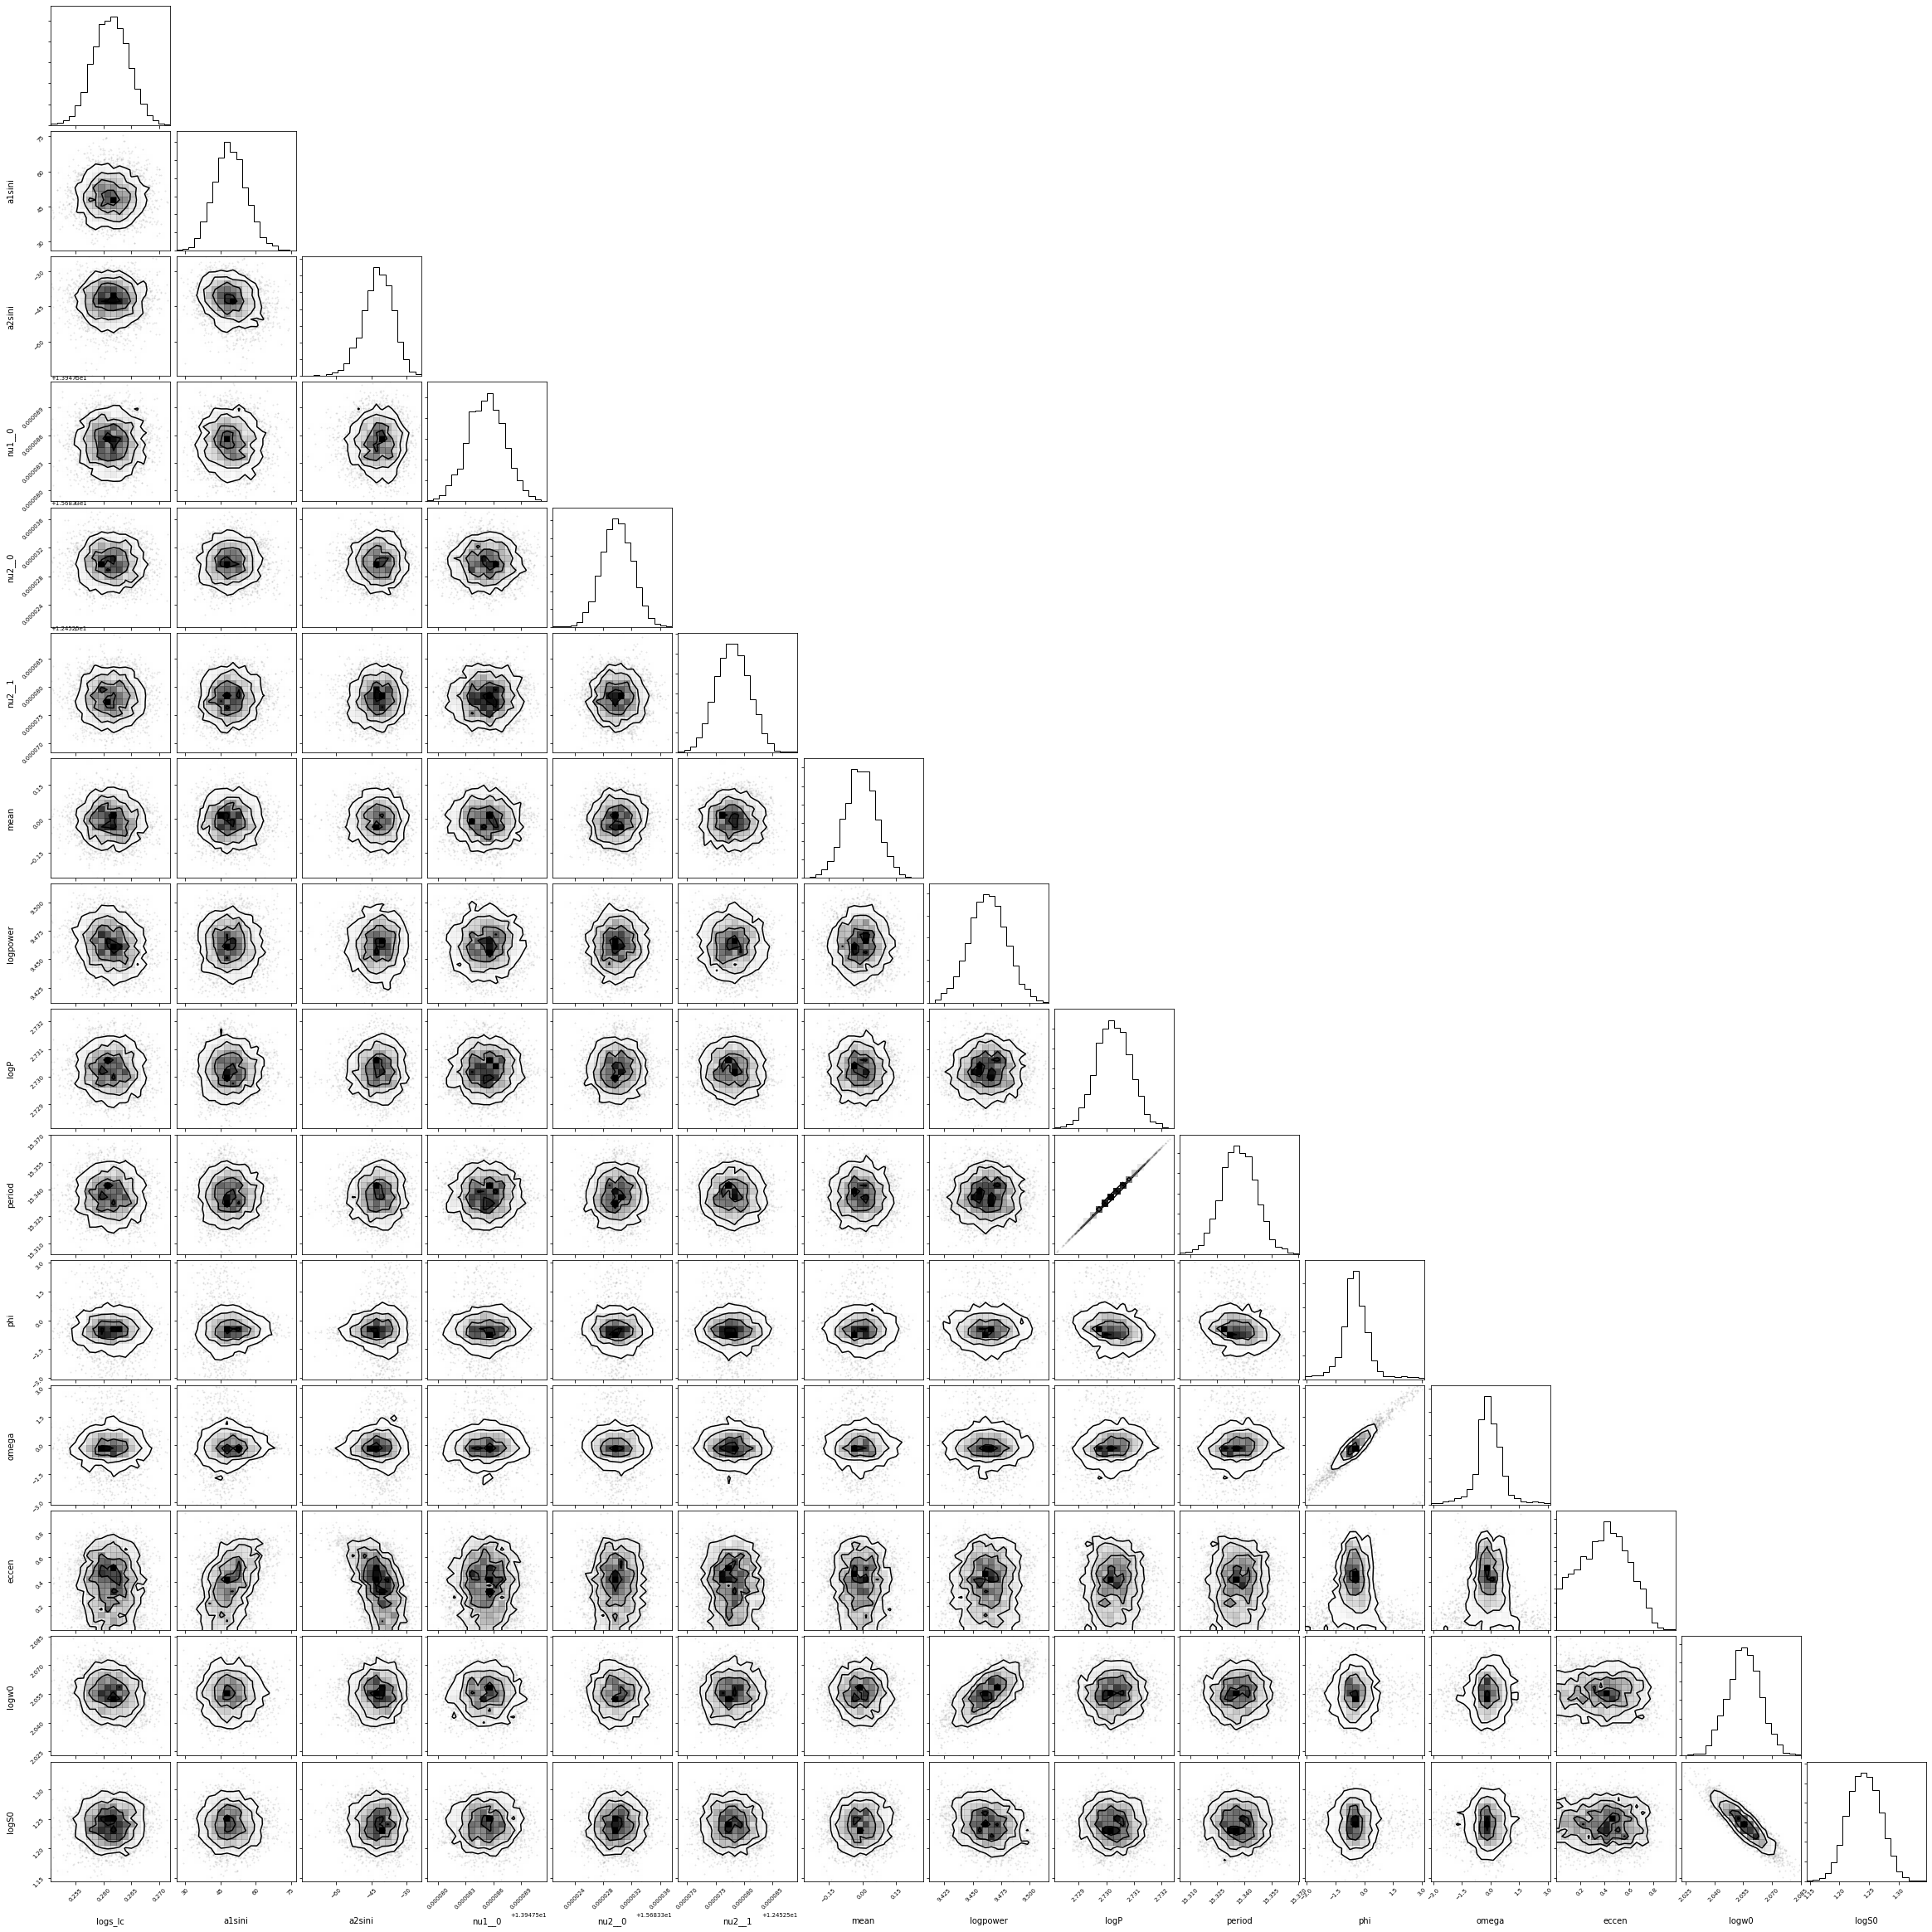

In [19]:
import corner

corner.corner(pm.trace_to_dataframe(trace));

In [28]:
varnames = ["period", "a1sini", "a2sini","eccen", "omega", "phi"]
for var in varnames:
    percentiles = np.percentile(trace[var], q=[15.87, 50, 84.13])
    print(f'{var}: {percentiles[1]:.2f} + {percentiles[2] - percentiles[1]:.2f} - {percentiles[1] - percentiles[0]:.2f}')

period: 15.34 + 0.01 - 0.01
a1sini: 49.02 + 7.27 - 6.77
a2sini: -41.87 + 6.11 - 6.70
eccen: 0.40 + 0.20 - 0.23
omega: -0.11 + 0.64 - 0.51
phi: -0.51 + 0.61 - 0.53


In [ ]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'a1sini'])
mfs = mass_function(samples['PB1_period'].values * u.day, samples['PB1_asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))